In [1]:
import numpy as np
import pandas as pd
import opensim as osim
from connections import AWS
from biomech.algorithms import diff_three_point
from biomech.opensim.inverse_kinematics import load_mot_file

$\textbf{OpenSim: Joint Reaction Analysis (Development)}$

In [2]:
def update_jra_settings(jra: osim.JointReaction) -> osim.JointReaction:
    """Update the JointReaction analysis settings. Includes joint names, body, and frame references."""    
    
    # set joints and forces to report
    joint_names = osim.ArrayStr()
    joint_names.append("radius_hand_r")           # NOTE: this depends on throwing hand
    joint_names.append("radioulnar_r")           # NOTE: this depends on throwing hand
    joint_names.append("elbow_r")           # NOTE: this depends on throwing hand
    jra.setJointNames(joint_names)

    # set body for analysis (child)
    on_body = osim.ArrayStr()
    on_body.append("child")
    jra.setOnBody(on_body)

    # set frame for analysis (child)
    in_frame = osim.ArrayStr()
    in_frame.append("child")
    jra.setInFrame(in_frame)

    return jra


In [3]:
""" SETUP JOINT REACTION ANALYSIS """
# initialize analysis
jra = osim.JointReaction('jra_right.xml')
jra.setName("trial")

# load model (TODO: clean up)
model = osim.Model('trial_model.osim')

[info] Loaded model models_arm_right_scaled from file trial_model.osim
[warning] Couldn't find file 'humerus_rv.vtp'.
[warning] Couldn't find file 'ulna_rv.vtp'.
[warning] Couldn't find file 'radius_rv.vtp'.
[warning] Couldn't find file 'pisiform_rvs.vtp'.
[warning] Couldn't find file 'lunate_rvs.vtp'.
[warning] Couldn't find file 'scaphoid_rvs.vtp'.
[warning] Couldn't find file 'triquetrum_rvs.vtp'.
[warning] Couldn't find file 'hamate_rvs.vtp'.
[warning] Couldn't find file 'capitate_rvs.vtp'.
[warning] Couldn't find file 'trapezoid_rvs.vtp'.
[warning] Couldn't find file 'trapezium_rvs.vtp'.
[warning] Couldn't find file 'metacarpal2_rvs.vtp'.
[warning] Couldn't find file 'index_proximal_rvs.vtp'.
[warning] Couldn't find file 'index_medial_rvs.vtp'.
[warning] Couldn't find file 'index_distal_rvs.vtp'.
[warning] Couldn't find file 'metacarpal3_rvs.vtp'.
[warning] Couldn't find file 'middle_proximal_rvs.vtp'.
[warning] Couldn't find file 'middle_medial_rvs.vtp'.
[warning] Couldn't find f

In [4]:
""" SETUP ANALYSIS TOOL """
analyze_tool = osim.AnalyzeTool('jra_right.xml')
analyze_tool.setName("test")
analyze_tool.setModel(model)
analyze_tool.addAnalysisSetToModel()

# set JRA details
analyze_tool.setModelFilename("trial_model.osim")
analyze_tool.setCoordinatesFileName("trial.mot")

# set start/end time
mot_data = load_mot_file("trial.mot")
analyze_tool.setStartTime(mot_data['time'].values[0])
analyze_tool.setFinalTime(mot_data['time'].values[-1])
analyze_tool.setLowpassCutoffFrequency(18)


[info] AbstractTool jra_tool loading model trial_model.osim
[info] Loaded model models_arm_right_scaled from file trial_model.osim
[warning] Couldn't find file 'humerus_rv.vtp'.
[warning] Couldn't find file 'ulna_rv.vtp'.
[warning] Couldn't find file 'radius_rv.vtp'.
[warning] Couldn't find file 'pisiform_rvs.vtp'.
[warning] Couldn't find file 'lunate_rvs.vtp'.
[warning] Couldn't find file 'scaphoid_rvs.vtp'.
[warning] Couldn't find file 'triquetrum_rvs.vtp'.
[warning] Couldn't find file 'hamate_rvs.vtp'.
[warning] Couldn't find file 'capitate_rvs.vtp'.
[warning] Couldn't find file 'trapezoid_rvs.vtp'.
[warning] Couldn't find file 'trapezium_rvs.vtp'.
[warning] Couldn't find file 'metacarpal2_rvs.vtp'.
[warning] Couldn't find file 'index_proximal_rvs.vtp'.
[warning] Couldn't find file 'index_medial_rvs.vtp'.
[warning] Couldn't find file 'index_distal_rvs.vtp'.
[warning] Couldn't find file 'metacarpal3_rvs.vtp'.
[warning] Couldn't find file 'middle_proximal_rvs.vtp'.
[warning] Couldn't 

/Users/cmoore/Library/Mobile Documents/com~apple~CloudDocs/Human RITHM/GitHub/pitch-ml/packages/biomech/opensim/inverse_kinematics.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(path, delim_whitespace=True, skiprows=10)


In [5]:
# run analysis
analyze_tool.run()

[info] No external loads will be applied (external loads file not specified).
[info] Loading coordinates from file 'trial.mot'.
[info] Storage: read data file = trial.mot (nr=342 nc=11)
[info] Low-pass filtering coordinates data with a cutoff frequency of 18.0...
[info] Found 684 state vectors with time stamps ranging from 0.0525 to 1.4868.
[info] Executing the analyses from 0.4116 to 1.1277...
[info] Printing results of investigation test to 


True

$\textbf{Development: Pipeline}$

Dynamically load and update subject models/files to run tool and store results.

In [6]:
import traceback
import xml.etree.ElementTree as ET
from biomech.opensim import load_osim_model

In [7]:
# load a .mot file (e.g., results from an IK run)
def load_mot_file(path: str, skip_rows: int = 10) -> pd.DataFrame:
    return pd.read_csv(path, delim_whitespace=True, skiprows=skip_rows)

# update scaling tool XML for subject
    # subject_id: subject to scale (info loaded from json)
def update_model_hand_segment(
    tree: ET.ElementTree,
    throwing_hand: str,
    ball_mass: float = 0.145,                                       # mass of ball
    ball_radius: float = 0.0368,                                    # radius of ball
) -> None:

    root = tree.getroot()

    # find the hand body
    match throwing_hand:
        case 'left':
            hand_body = root.find(".//Body[@name='hand_l']")
        case 'right':
            hand_body = root.find(".//Body[@name='hand_r']")
    
    # update mass (+= 0.145)
        # combined center of mass computed with mass weighted avg of two bodies
    hand_mass = hand_body.find(".//mass")
    hand_mass.text = str(float(hand_mass.text) + ball_mass)
    
    # update mass center using mass wtd avgs
    com_new = compute_combined_com(float(hand_mass.text), ball_mass)
    hand_com = hand_body.find(".//mass_center")
    hand_com.text = ' '.join(map(str, com_new)) 

    # update inertia tensor as hand-ball segment
        # uses updated mass, mass center
        # tensor computed using parallel axis theorem
    I_new = compute_combined_inertia(float(hand_mass.text), com_new, m_ball=ball_mass, r_ball=ball_radius)
    hand_inertia = hand_body.find(".//inertia")
    hand_inertia.text = ' '.join(map(str, [I_new[0, 0], I_new[1, 1], I_new[2, 2], 0, 0, 0]))

    return tree

# compute combined CoM using mass wtd avgs
def compute_combined_com(
        m_hand: float,
        m_ball: float = 0.145           # mass of regulation ball in kg
) -> np.ndarray:

    # center of mass
    com_hand = np.array([0, -0.068095, 0])  
    com_ball = np.array([0.0368, -0.068095, 0])                                     # ball CoM shifted in x-direction
    com_new = (m_hand * com_hand + m_ball * com_ball) / (m_hand + m_ball)           # combined CoM

    return com_new

# compute combined inertia tensor using parallel axis theorem
def compute_combined_inertia(
        m_hand: float,
        com_combined: np.ndarray,
        com_hand: np.ndarray = np.array([0, -0.068095, 0]),
        com_ball: np.ndarray = np.array([0.0368, -0.068095, 0]),                    # ball CoM in hand frame shifted in x-direction by radius of ball
        m_ball: float = 0.145,                                                      # mass of regulation ball in kg
        r_ball: float = 0.0368,                                                     # radius of regulation ball in m
):
    # compute updated axes
    com_hand_prime = com_hand - com_combined
    com_ball_prime = com_ball - com_combined

    # inertia tensors (original; hand from rajagopal model)
    I_hand = np.diag([0.00093985399999999995, 
                    0.00057634600000000004, 
                    0.0014118900000000001])
    I_ball = 2/5 * m_ball * r_ball**2 * np.eye(3)  # ball inertia tensor; uniform density sphere

    # update inertia tensors through new axes -- parallel axis theorem
    I_hand_prime = I_hand + m_hand * (skew(com_hand_prime) @ skew(com_hand_prime))
    I_ball_prime = I_ball + m_ball * (skew(com_ball_prime) @ skew(com_ball_prime))

    # combined inertia tensor
    I_new = I_hand_prime + I_ball_prime

    return I_new

# create a skew symmetric matrix from a vector
def skew(vector: np.ndarray) -> np.ndarray:
    if len(vector) != 3:
        raise ValueError("Input vector must have exactly 3 elements.")

    return np.array([
        [0, -vector[2], vector[1]],
        [vector[2], 0, -vector[0]],
        [-vector[1], vector[0], 0]
        ])


In [8]:
""" INITIALIZE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


In [9]:
# load all subject info
subject_info = aws_connection.load_subject_info()

# load all (filtered) IK files
s3_objects = aws_connection.list_s3_objects(prefix='biomechanics/subjects/')
mot_files = [obj for obj in s3_objects if obj.endswith('.mot') and '_ik' in obj]

# set XML dir path 
XML_DIR = 'biomechanics/xml_templates'

In [ ]:
# initialize error log
error_log = []

# iterate through subjects
for subject in subject_info['subject_id'].unique()[0:2]:
    
    try:
        # get subject info (ID -- string; throwing hand)
        subject_id = str(subject)
        throwing_hand = subject_info[subject_info['subject_id'] == subject]['throws'].values[0]

        # list all subject trials (in trc_processed) & iterate through
        subject_trials = [t for t in mot_files if f'{subject_id}' in t]
        
        if len(subject_trials) > 0:
            print(f'Processing subject {subject_id} with {len(subject_trials)} trials...')

            
            """ FILE LOADING & SETUP """

            # TODO: update scaled model hand-ball segment, re-upload to S3
                    # open subject model XML from S3 --> write to local file
            scaled_model_xml = aws_connection.load_xml_from_s3(f'biomechanics/subjects/{subject_id}/osim/{subject_id}_scaled_model.osim')
            scaled_model_tree = ET.ElementTree(scaled_model_xml)

            # update hand ball segment properties
            scaled_model_tree_hb = update_model_hand_segment(
                scaled_model_tree,
                throwing_hand=throwing_hand
            )

            # write model (local & S3)
            scaled_model_tree_hb.write(f'trial_model.osim')
            with open(f'trial_model.osim', 'r') as f:
                scaled_model_content = f.read()
            aws_connection.upload_to_s3(
                scaled_model_content,
                f'biomechanics/subjects/{subject_id}/osim/{subject_id}_scaled_model_hb.xml', 
        )

            # load subject model for trials
            scaled_model = osim.Model(f'trial_model.osim')

            # load JRA template & scaled model for saving to local directory
            jra_template = aws_connection.load_xml_from_s3(f'{XML_DIR}/jra_{throwing_hand}.xml')
            jra_template_tree = ET.ElementTree(jra_template)
            jra_template_tree.write(f'jra_{throwing_hand}.xml')

            # iterate through trials
                # NOTE: creating tools with functions leads to kernel crashing
            for t in subject_trials:

                # get trial ID from file name
                trial_id = t.split('/')[-1].split('_ik')[0]

                # download .mot file from S3 to local directory
                aws_connection.s3.download_file(
                    aws_connection.bucket_name,
                    t,
                    'trial.mot'
                )

                """ SETUP JOINT REACTION ANALYSIS """
                # initialize analysis
                jra = osim.JointReaction('jra_right.xml')
                jra.setName("trial")

                # load model
                model = osim.Model('trial_model.osim')

                """ SETUP ANALYSIS TOOL """
                analyze_tool = osim.AnalyzeTool(f'jra_{throwing_hand}.xml')
                analyze_tool.setName(f"trial")
                analyze_tool.setModel(model)
                analyze_tool.addAnalysisSetToModel()

                # set JRA details
                analyze_tool.setModelFilename("trial_model.osim")
                analyze_tool.setCoordinatesFileName("trial.mot")

                # set start/end time
                mot_data = load_mot_file("trial.mot")
                analyze_tool.setStartTime(mot_data['time'].values[0])
                analyze_tool.setFinalTime(mot_data['time'].values[-1])

                # run tool
                analyze_tool.run()

                # upload setttings to S3
                analyze_tool.printToXML('trial_settings.xml')
                aws_connection.s3.upload_file(
                    f'trial_settings.xml', 
                    aws_connection.bucket_name,
                    f'biomechanics/subjects/{subject_id}/inverse_dynamics/{trial_id}_jra_template.xml'
                )

                # upload trial & results to S3 
                    # the .mot file is the same as the IK results, but makes for easier debugging / repro
                    # can easily load .sto file using pd.read_csv(f, skiprows=11) after loading bytes from S3
                aws_connection.s3.upload_file(
                    f'trial_JointReaction_ReactionLoads.sto', 
                    aws_connection.bucket_name,
                    f'biomechanics/subjects/{subject_id}/inverse_dynamics/{trial_id}_jra_results.sto'
                )
                aws_connection.s3.upload_file(
                    f'trial.mot', 
                    aws_connection.bucket_name,
                    f'biomechanics/subjects/{subject_id}/inverse_dynamics/{trial_id}_jra_trial.mot'
                )

    
    # error handling
    except Exception as e:
        print(f"Error processing subject {subject_id}: {e}")

        traceback.print_exc()

        # log error
        error_log.append({
            'subject_id': subject_id,
            'error': str(e)
        })

        continue

Processing subject 2609 with 19 trials...
[AWS]: Uploaded object to s3://pitch-ml/biomechanics/subjects/2609/osim/2609_scaled_model_hb.xml
[info] Loaded model models_arm_right_scaled from file trial_model.osim
[warning] Couldn't find file 'humerus_rv.vtp'.
[warning] Couldn't find file 'ulna_rv.vtp'.
[warning] Couldn't find file 'radius_rv.vtp'.
[warning] Couldn't find file 'pisiform_rvs.vtp'.
[warning] Couldn't find file 'lunate_rvs.vtp'.
[warning] Couldn't find file 'scaphoid_rvs.vtp'.
[warning] Couldn't find file 'triquetrum_rvs.vtp'.
[warning] Couldn't find file 'hamate_rvs.vtp'.
[warning] Couldn't find file 'capitate_rvs.vtp'.
[warning] Couldn't find file 'trapezoid_rvs.vtp'.
[warning] Couldn't find file 'trapezium_rvs.vtp'.
[warning] Couldn't find file 'metacarpal2_rvs.vtp'.
[warning] Couldn't find file 'index_proximal_rvs.vtp'.
[warning] Couldn't find file 'index_medial_rvs.vtp'.
[warning] Couldn't find file 'index_distal_rvs.vtp'.
[warning] Couldn't find file 'metacarpal3_rvs.vt

In [27]:
# concatenate error log
error_log_df = pd.DataFrame(error_log)

# write error log to S3 bucket
aws_connection.upload_to_s3(
    error_log_df.to_csv(index=False),
    'subjects/summary/error_jra_log.csv'
)

[AWS]: Uploaded object to s3://pitch-ml/subjects/summary/error_jra_log.csv


$\textbf{Post-Development Plotting}$

<Axes: >

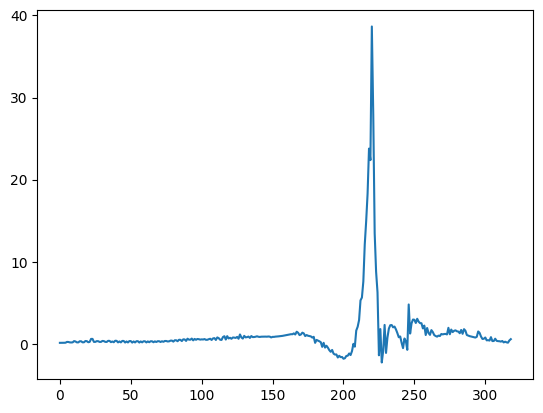

In [12]:
# load & plot trial data
trial_data = pd.read_csv('trial_JointReaction_ReactionLoads.sto', sep='\\s+', skiprows=11)
trial_data['elbow_l_on_ulna_l_in_ulna_l_mx'].plot()